<a href="https://colab.research.google.com/github/EugenHotaj/nn-hallucinations/blob/master/cppn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reset -f

In [0]:
!pip install noise
!rm -rf nn_hallucinations
!git clone https://www.github.com/EugenHotaj/nn-hallucinations nn_hallucinations

Cloning into 'nn_hallucinations'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 16), reused 10 (delta 4), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [0]:
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from nn_hallucinations import colab_utils
from noise import perlin
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.nn import init
from torchvision import transforms

# Needed to display animations inline in Colab.
matplotlib.rcParams['animation.html'] = 'html5'
print(colab_utils.get_device())

cuda


# Random Networks

In [0]:
def init_weights(layer):
  """Initializes layer weights and biases.
  
  The weights are randomly sampled from a unit normal distribution. This is 
  extremley important to produce pleasing images. Using Xavier or Kaiming 
  initialization leads to gray images being produces as the model output tends
  closer to .5 with deeper and deeper networks. 

  The bias initialization is largely irrelevant so we initialize to 1.

  Args:
    layer: The layer to initialize.
  """
  if type(layer) == nn.Linear:
    init.normal_(layer.weight)
    init.constant_(layer.bias, 1.)

def random_fcnn(n_layers, n_units, activation=nn.Tanh):
  """Creates a randomly initialized Fully Connected Neural Network.
  
  Args:
    n_layers: The number of hidden layers in the network.
    n_units: The number of units in each hidden layer.
    activation: The activation to use after each fully connected layer.
  Returns:
    The Fully Connectd Neural Network.
  """
  n_inputs, n_outputs = 2, 3  # (x, y) -> (r, g, b)
  model = nn.Sequential(
      nn.Linear(in_features=n_inputs, out_features=n_units),
      activation())
  for i in range(n_layers):
    model.add_module(
        name=f'fc_{i}', 
        module=nn.Linear(in_features=n_units, out_features=n_units))
    model.add_module(name=f'activation_{i}', module=activation())
  model.add_module(
      name='logits',
      module=nn.Linear(in_features=n_units, out_features=n_outputs))
  model.add_module(name='output', module=nn.Sigmoid())
  return model


def scale(x):
  """Scales the input to be in [0, 1].

  This is extremley important to produce peasing images, otherwise all you'll
  see are straight lines.

  Args:
    x: The matrix to scale to [0, 1] column wise.
  """ 
  min_size, max_size = np.min(x, axis=0), np.max(x, axis=0)
  return (x - min_size) / (max_size - min_size)


def generate_input_image(imsize=(100, 100)):
  """Generates scaled (x, y) coordinates for images of size imsize."""
  width, height = imsize
  meshgrid = np.meshgrid(range(width), range(height))
  coordinates = np.dstack(meshgrid).reshape((-1, 2)).astype(np.float32)
  # Swap to get coordinates in (x, y) instead of the (y, x) output from dstack.
  coordinates = coordinates[:, [1, 0]]
  coordinates = scale(coordinates)
  return coordinates


def reshape_output_image(image, imsize=(100, 100)):
  """Reshapes the given image to (imsize, imsize, 3)."""
  width, height = imsize
  return image.view(width, height, 3).permute(2, 0, 1)

In [0]:
def animate(frames, figsize=None, fps=24):
  """Renders the frames together into an animation.
  
  Args:
    frames: Either a list, iterator, or generator of images in torch.Tensor 
      format.
    figsize: The display size for the animation; passed to Matplotlib.
    fps: The number of frames to render per second (i.e. frames per second).
  Returns:
    The Matplotlib animation object.
  """
  fig = plt.figure(figsize=figsize)
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
  plt.axis('off')

  image_unloader = transforms.Compose([
      transforms.Lambda(lambda x: x.cpu().clone().squeeze(0)),
      transforms.ToPILImage()
  ])

  image = plt.imshow([[0, 0], [0, 0]])
  
  def animate_fn(frame):
    frame = image_unloader(frame)
    image.set_data(frame)
    return image,

  anim = animation.FuncAnimation(
      fig, 
      animate_fn, 
      frames=frames, 
      interval=1000 / fps,
      blit=True,
      # Caching frames causes OOMs in Colab when there are a lot of frames or 
      # the size of individual frames is large.
      cache_frame_data=False)
  plt.close(anim._fig)
  return anim

In [0]:
class ModelUpdater():
  
  def __init__(self, n_frames):
    self._n_frames = n_frames
    self._simplex_noises = []
    for _ in range(8):
      noise = perlin.SimplexNoise()
      noise.randomize()
      self._simplex_noises.append(noise)

  def update(self, model, frame):
    theta = frame / self._n_frames * 2 * np.pi
    x = np.cos(theta)
    y = np.sin(theta)
    t = [0]

    def apply_fn(layer):
      if type(layer) == nn.Linear:
        noise = self._simplex_noises[t[0]]
        delta = noise.noise2(x * .02, y * .02)
        layer.weight.data += .005 * delta
        t[0] += 1
        
    model.apply(apply_fn)


class FrameIterator():

  def __init__(self, model, model_updater, imsize, n_frames=100):
    self._model = model
    self._model_updater = model_updater 
    self._imsize = imsize
    self._n_frames = n_frames

  def _new_iterator(self):
    image = generate_input_image(imsize=imsize)
    image = torch.tensor(image)
    for frame in range(self._n_frames):
      output = self._model(image)
      output = reshape_output_image(output, self._imsize)
      yield output
      self._model_updater.update(model, frame)

  def __iter__(self):
    return self._new_iterator()

  def __len__(self):
    return self._n_frames

In [0]:
imsize = (800, 800)
n_layers = 6
n_units = 32
fps = 24
n_frames = 1 * fps

model = random_fcnn(n_layers, n_units)
model.apply(init_weights)

model_updater = ModelUpdater(n_frames)
frame_iterator = FrameIterator(model, model_updater, imsize, n_frames)
animate(frame_iterator, figsize=(20, 20), fps=fps)

# Image Regression

[100]: loss=649.3141207885742
[200]: loss=420.30968353271487
[300]: loss=374.88008575439454
[400]: loss=253.27989898681642
[500]: loss=159.96354217529296
[600]: loss=81.9999607849121
[700]: loss=68.88172241210937
[800]: loss=64.73981967926025
[900]: loss=61.45765571594238
[1000]: loss=58.26441917419434
[1100]: loss=54.68611011505127
[1200]: loss=50.206027297973634
[1300]: loss=45.03571838378906
[1400]: loss=41.43043563842773
[1500]: loss=36.33275871276855
[1600]: loss=33.648435039520265
[1700]: loss=31.52573143005371
[1800]: loss=29.61966802597046
[1900]: loss=28.571652240753174
[2000]: loss=27.015799770355226
[2100]: loss=26.123053550720215
[2200]: loss=25.137061252593995
[2300]: loss=24.28873025894165
[2400]: loss=23.375569190979004
[2500]: loss=22.46490560531616
[2600]: loss=22.10568416595459
[2700]: loss=20.773155555725097
[2800]: loss=20.331410121917724
[2900]: loss=19.261857128143312
[3000]: loss=18.77522701263428
[3100]: loss=18.49533931732178
[3200]: loss=17.83794836997986
[330

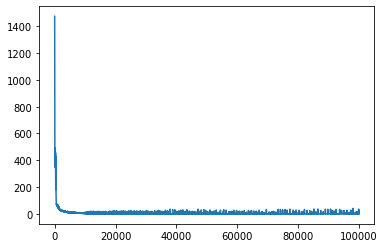

In [0]:
input_img = content_img.clone().to(get_device())
imsize = tuple(input_img.shape[2:])
n_layers = 12
n_units = 64

model = random_fcnn(n_layers, n_units, activation=nn.Tanh).to(get_device())
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.AdamW(model.parameters())

coordinates = generate_input_image(imsize)
coordinates = torch.tensor(
    coordinates, requires_grad=False, device=get_device())
losses = []
running_loss = 0
for i in range(100000):
  optimizer.zero_grad()
  preds = model(coordinates)
  preds = preds.reshape((1, *imsize, -1)).permute([0, 3, 1, 2])
  loss = criterion(preds, input_img)
  running_loss += loss.item()
  losses.append(loss.item())
  loss.backward()
  optimizer.step()

  if (i+1) % 100 == 0:
    print(f'{[i+1]}: loss={running_loss/100}')
    running_loss = 0
plt.plot(range(len(losses)), losses)

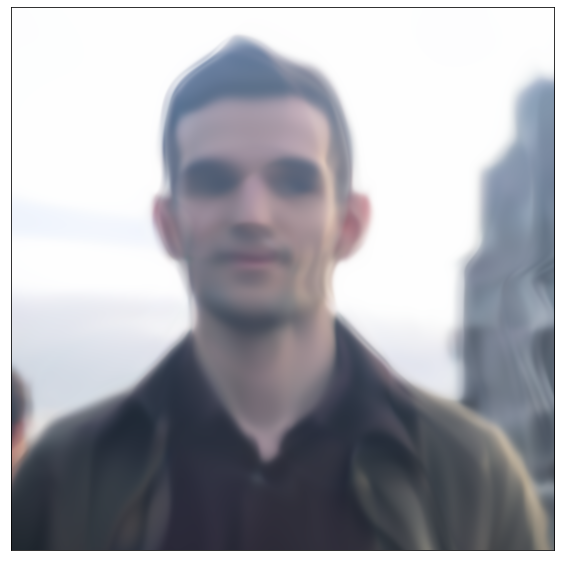

In [0]:
output_imsize = (1024, 1024)
coordinates = generate_input_image(imsize=output_imsize)
coordinates = torch.tensor(coordinates, requires_grad=False)
image = model.to('cpu')(coordinates).data.cpu().numpy()
image = reshape_output_image(image, imsize=output_imsize)
plt.figure(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(image)